In [178]:
import os
import glob
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_erosion, disk 
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes, center_of_mass, binary_erosion
from skimage.filters import threshold_otsu, median 
from skimage.exposure import rescale_intensity 

# --- Variáveis Globais ---

# Caminho para o diretório de dados, relativo ao notebook em 'src/'
DATA_DIR = '../database/axl/'

# Número de imagens aleatórias para o batch
N_IMAGES_BATCH = 15

# Número de clusters (3 = LCR, Matéria Cinzenta, Matéria Branca)
N_CLUSTERS = 5 

# Limite mínimo de área (em pixels) para um componente ser considerado
MIN_VENTRICLE_AREA = 100

# Lista para armazenar os caminhos dos arquivos selecionados para o batch
SELECTED_FILES = []

# Lista para armazenar os slices 2D originais para usar na Célula 3
ORIGINAL_SLICES = []

# Seed para reprodutibilidade
random.seed(64)

print("Célula 1 executada: Bibliotecas importadas e variáveis globais definidas.")

Célula 1 executada: Bibliotecas importadas e variáveis globais definidas.


Carregando e exibindo 15 imagens aleatórias antes da segmentação...


Carregando e exibindo 15 imagens aleatórias antes da segmentação...


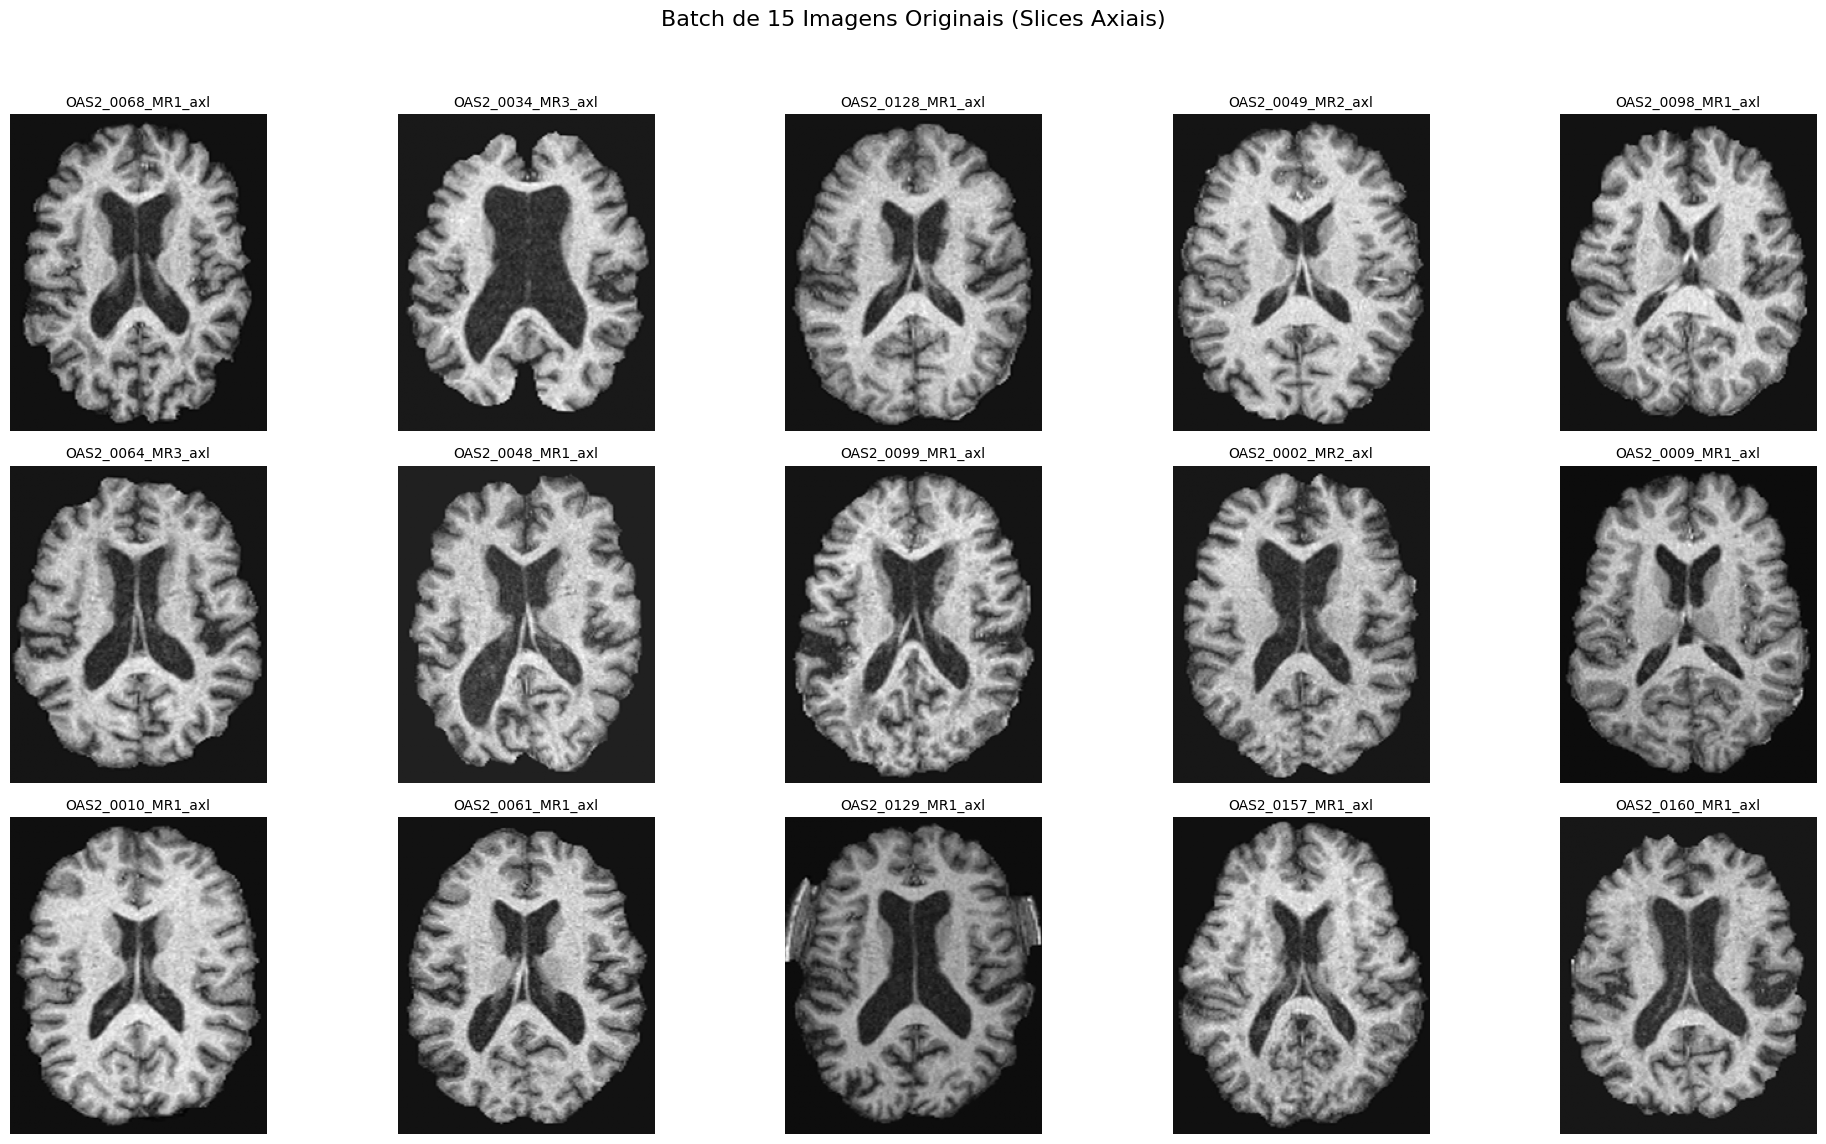

In [179]:
# CÉLULA 2: Visualização de um Batch de Imagens Originais

print("Carregando e exibindo 15 imagens aleatórias antes da segmentação...")

# Limpa listas de execuções anteriores
SELECTED_FILES.clear()
ORIGINAL_SLICES.clear()

# 1. Encontrar todos os arquivos .nii.gz no diretório
all_files = glob.glob(os.path.join(DATA_DIR, '*.nii.gz'))

if not all_files:
    print(f"ERRO: Nenhum arquivo .nii.gz encontrado em {os.path.abspath(DATA_DIR)}")
    print("Verifique o caminho da variável DATA_DIR na Célula 1.")
else:
    # 2. Selecionar 15 arquivos aleatoriamente
    SELECTED_FILES = random.sample(all_files, min(N_IMAGES_BATCH, len(all_files)))
    
    # 3. Configurar o plot
    plt.figure(figsize=(20, 12))
    
    # 4. Carregar e exibir cada imagem
    plot_index = 1
    for i, file_path in enumerate(SELECTED_FILES):
        # Carregar o arquivo NIfTI
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        
        slice_2d = None
        
        if img_data.ndim == 3:
            # Se for um volume 3D, pega o slice axial central
            middle_slice_idx = img_data.shape[2] // 2
            slice_2d = img_data[:, :, middle_slice_idx]
        elif img_data.ndim == 2:
            # Se já for uma imagem 2D, usa diretamente
            slice_2d = img_data
        else:
            # Formato inesperado (ex: 4D), apenas ignora esta imagem
            print(f"Aviso: O arquivo {os.path.basename(file_path)} tem {img_data.ndim} dimensões. Pulando.")
            continue
            
        # Salvar o slice para usar na próxima célula
        ORIGINAL_SLICES.append(slice_2d)
        
        # Plotar
        plt.subplot(3, 5, plot_index)
        plot_index += 1
        
        # Usamos np.rot90() pois os dados NIfTI frequentemente precisam ser rotacionados para visualização
        plt.imshow(np.rot90(slice_2d), cmap='gray')
        
        # Extrair um nome de arquivo curto para o título
        filename = os.path.basename(file_path).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')
        
    plt.suptitle(f"Batch de {len(ORIGINAL_SLICES)} Imagens Originais (Slices Axiais)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Processando e segmentando as 15 imagens do batch...


Processando e segmentando as 15 imagens do batch...


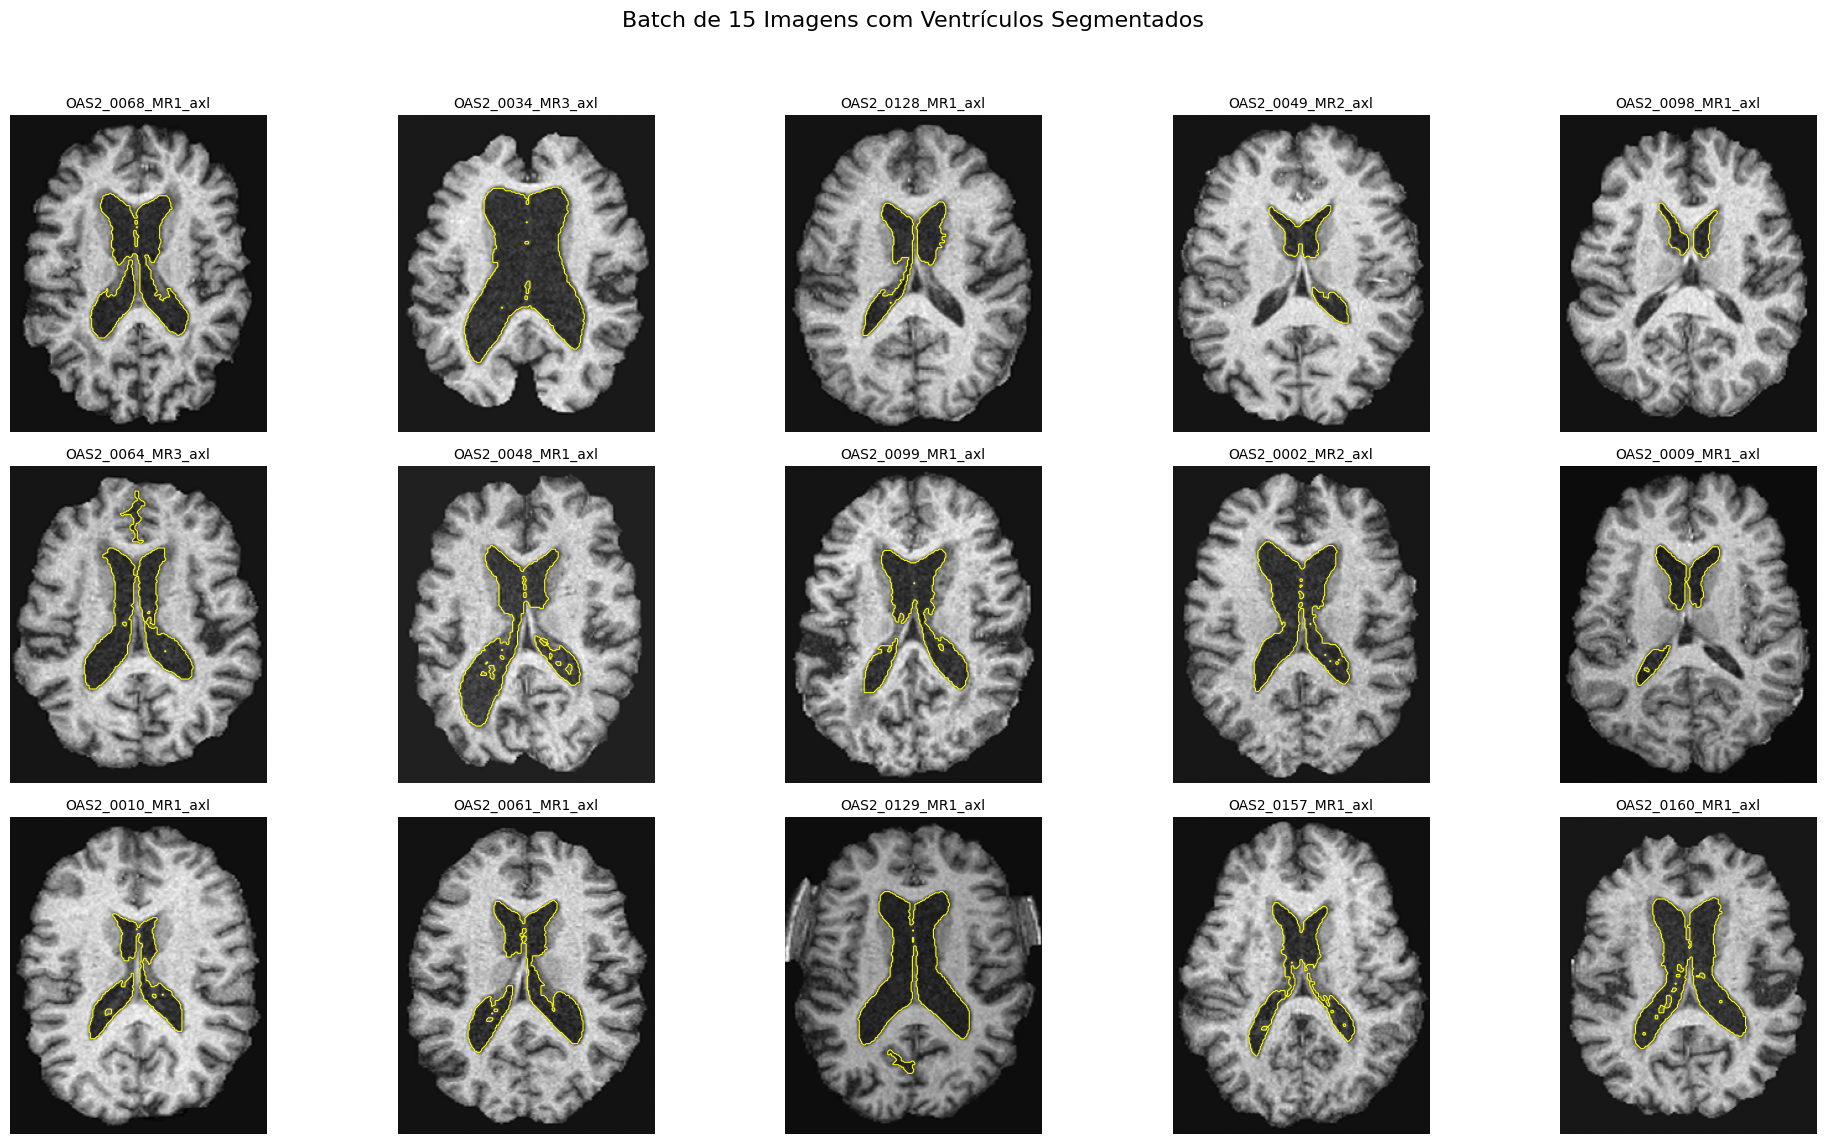

In [ ]:
# CÉLULA 3: Segmentação e Visualização (VERSÃO 5 - Pré-processamento + Lógica "Funil")

def segment_ventricles(image_slice_2d):
    """
    Segmenta os ventrículos laterais.
    Adiciona pré-processamento (Normalização + Filtro Mediano)
    à lógica "funil" (Centralidade + Área).
    """
    
    # --- INÍCIO PRÉ-PROCESSAMENTO ---
    
    # 1. Normalizar intensidade da imagem para [0.0, 1.0]
    # Isso torna o K-Means e Otsu mais estáveis entre imagens
    img_norm = rescale_intensity(image_slice_2d, out_range=(0.0, 1.0))
    
    # 2. Aplicar filtro de mediana para remover ruído
    # disk(1) é um filtro pequeno (kernel 3x3)
    img_denoised = median(img_norm, disk(1))
    
    # --- FIM PRÉ-PROCESSAMENTO ---

    # 3. Obter máscara do cérebro (Otsu)
    try:
        thresh = threshold_otsu(img_denoised)
        head_mask = img_denoised > thresh
    except ValueError:
        return np.zeros_like(img_denoised, dtype=bool)

    # 4. Preencher buracos e erodir para remover crânio
    head_mask_filled = binary_fill_holes(head_mask)
    brain_mask = binary_erosion(head_mask_filled, iterations=3)

    # 5. Extrair pixels *dentro* da máscara do cérebro
    brain_pixels = img_denoised[brain_mask].reshape(-1, 1)
    
    if brain_pixels.shape[0] < N_CLUSTERS:
        return np.zeros_like(img_denoised, dtype=bool)

    # 6. K-Means (com N_CLUSTERS=3)
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10).fit(brain_pixels)
    
    # 7. Encontrar o cluster do LCR 
    csf_cluster_label = np.argmin(kmeans.cluster_centers_)
    
    # 8. Criar a máscara binária inicial do LCR
    csf_mask = np.zeros_like(img_denoised, dtype=bool)
    csf_mask[brain_mask] = (kmeans.labels_ == csf_cluster_label)
    
    # --- LÓGICA DE LIMPEZA  ---
    
    # 9. Rotular todos os componentes de LCR encontrados
    labeled_mask = label(csf_mask)
    props = regionprops(labeled_mask)
    
    if not props:
        return np.zeros_like(img_denoised, dtype=bool)

    # 10. Encontrar o centro do cérebro
    brain_center = center_of_mass(brain_mask)

    # 11. Calcular a distância de cada componente ao centro
    components_with_distance = []
    for prop in props:
        if prop.area < MIN_VENTRICLE_AREA:
            continue
        component_center = prop.centroid
        distance = np.sqrt((brain_center[0] - component_center[0])**2 + 
                           (brain_center[1] - component_center[1])**2)
        components_with_distance.append((distance, prop))

    # 12. Ordenar pela distância (mais próximos primeiro)
    components_with_distance.sort(key=lambda x: x[0])

    # 13. Criar "grupo de busca" com os 5 componentes mais centrais
    search_group_props = [prop for dist, prop in components_with_distance[:5]]
    
    # 14. Deste grupo, ordenar pelos MAIORES em área
    search_group_props.sort(key=lambda p: p.area, reverse=True)

    # 15. Criar a máscara final com os 2 maiores deste grupo
    final_mask = np.zeros_like(labeled_mask, dtype=bool)
    
    if len(search_group_props) > 0:
        largest_prop = search_group_props[0]
        final_mask[labeled_mask == largest_prop.label] = True
        
    if len(search_group_props) > 1:
        second_largest_prop = search_group_props[1]
        final_mask[labeled_mask == second_largest_prop.label] = True
            
    return final_mask

# --- Lógica Principal da Célula 3 ---

print(f"Processando e segmentando as {len(ORIGINAL_SLICES)} imagens do batch...")

if not ORIGINAL_SLICES:
    print("ERRO: Nenhuma imagem carregada. Execute a Célula 2 primeiro.")
else:
    plt.figure(figsize=(20, 12))
    
    for i, image_slice in enumerate(ORIGINAL_SLICES):
        # 1. Gerar a máscara de segmentação
        ventricle_mask = segment_ventricles(image_slice)
        
        # 2. Plotar a imagem original
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.rot90(ORIGINAL_SLICES[i]), cmap='gray')
        
        # 3. Sobrepor o contorno da máscara
        if np.any(ventricle_mask):
            plt.contour(np.rot90(ventricle_mask), colors='yellow', linewidths=0.8)
            
        # 4. Título e eixos
        filename = os.path.basename(SELECTED_FILES[i]).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Batch de {len(SELECTED_FILES)} Imagens com Ventrículos Segmentados", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()